# CEIA - 16Co2024 - Visión por Computadora 1 - TP3

**Myrna L. Degano (a1618)**  
**Gustavo J. Rivas (a1620)** 

## Objetivo

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en "Material_TPs/TP3/images" a partir del template ["Material_TPs/TP3/template"](./template/pattern.png)



In [53]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

(175, 400, 3)


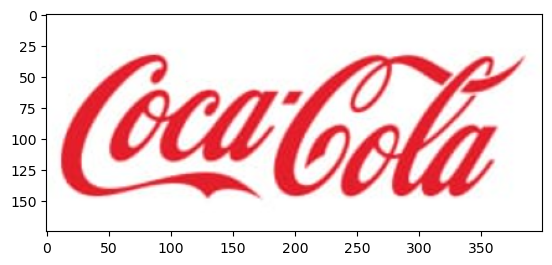

In [55]:
# Template a matchear
template_bgr = cv.imread('./template/pattern.png')

template_rgb= cv.cvtColor(template_bgr, cv.COLOR_BGR2RGB)

plt.figure()
plt.imshow(template_rgb)
print(template_bgr.shape)

In [57]:
def cropTemplate(img):
    """
    Recorta los bordes blancos del template para asegurar el match
    * Inputs: template en formato bgr
    * Outputs: template recortado en el mismo formato de entrada
    """

    # Identificar fondo blanco para recortar template
    _, binary = cv.threshold(cv.cvtColor(img, cv.COLOR_BGR2GRAY), 245, 255, cv.THRESH_BINARY)
    
    rows = np.all(binary == 255, axis=1)  # Fila completamente blanca
    cols = np.all(binary == 255, axis=0)  # Columna completamente blanca
    non_white_rows = np.where(~rows)[0] # Fila no blanca
    non_white_cols = np.where(~cols)[0] # Columna no blanca
    
    # Recortar la imagen para eliminar los bordes blancos
    cropped_template = img[non_white_rows.min():non_white_rows.max() + 1, 
                           non_white_cols.min():non_white_cols.max() + 1]

    return cropped_template
   

(121, 376, 3)


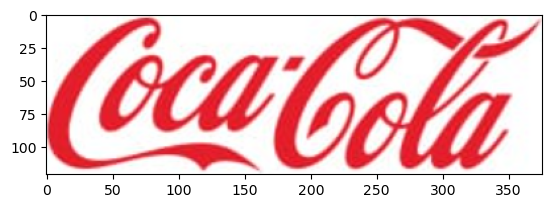

In [59]:
cropped_template_rgb= cv.cvtColor(cropTemplate(template_bgr), cv.COLOR_BGR2RGB)

plt.figure()
plt.imshow(cropped_template_rgb)
print(cropped_template_rgb.shape)

## 1. 

Obtener una detección del logo en cada imagen sin falsos positivos.

In [63]:
path = Path('./images/')
# Todas las imágenes de la carpeta images
all_files = [p for p in path.iterdir() if p.suffix in ['.png', '.jpg']]

De la exploración del conjunto de imágenes y pruebas con los diferentes métodos disponibles, decidimos utilizar TM_CCOEFF, que es el que arroja mejores resultados en este caso.  

Realizando pruebas de preprocesamiento sobre el conjunto de imágenes para eliminar falsos positivos, llegamos a la conclusión que no es necesario aplicar filtros de desenfoque, sólo ajuste de brillo/contraste según el caso, y el uso del método normalizado (TM_CCOEFF_NORM) para aquellas imágenes que tienen condiciones particulares de iluminación.    


In [66]:
def preProcessImg(image, threshold):
    """
    Aplica preprocesamiento sobre la imagen 
    para asegurar la detección sin falsos positivos
    Inputs:
    * image: imagen en escala de grises
    * threshold: umbral para la toma de decisiones
    Outputs:
    * Imagen ajustada y método a utilizar para el matching
    """

    # Intensidad promedio de la imagen
    mean_intensity = np.mean(image)
    # Desvío estándar - Nivel de contraste
    contrast = np.std(image)
    
    method_name = 'CCOEFF' # Default

    if mean_intensity < threshold:
        # Para niveles de intensidad menores, ajustar brillo y contraste
        new_image = cv.convertScaleAbs(image, alpha=0.5, beta=0.5)
    else:
        new_image = image
        if contrast < threshold:
            # Para niveles de contraste inferiores, utilizar normalización
            method_name = 'CCOEFF_NORMED'
            
    return new_image, method_name

Para la métrica del nivel de confianza de la detección, tomamos como referencia, el valor que hubiera dado el match si el template fuera un recorte exacto de la imagen.

In [69]:
def getMetric(image, bestScale, bestVal, bestPos, method):
    """
    Calcula el nivel de confianza de la detección
    Inputs:
    * image: Imagen a procesar
    * bestScale: tamaño del template
    * bestVal: valor del matching
    * bestPos: posición inicial de la detección
    * method: método empleado para la detección
    Outputs:
    * Nivel de confianza de la detección
    """

    # Recortar de la imagen la porción equivalente al template
    x1, y1 = bestPos # Esquina superior izquierda
    x2, y2 = (bestPos[0]+bestScale[1], bestPos[1] + bestScale[0])  # Esquina inferior derecha
    template = image[y1:y2, x1:x2]

    # Calcular el valor que daría la coincidencia perfecta
    result = cv.matchTemplate(image, template, eval('cv.TM_'+ method))
    _, max_val, _, _ = cv.minMaxLoc(result)

    # Ponderar el valor obtenido con relación al ideal
    return bestVal*100/max_val


Para escalar el template, primero acotamos el máximo al ancho de la imagen y luego reducimos su tamaño incrementalmente.

In [72]:
def templateSizes(image_size, template_size, scale_from, scale_to):
    """
    Devuelve array de tamaños posibles del template
    aplicando factor de escalamiento 
    desde/hasta el rango indicado
    manteniendo las proporciones
    partiendo del ancho de la imagen a procesar 
    y reduciendo la escala
    Inputs:
    * image_size: tamaño de la imagen a procesar
    * template_size: tamaño original del template
    * scale_from / scale_to: factor de escalamiento desde/hasta
    """
    
    template_sizes = []
    # Alinear ancho del template y la imagen 
    # para asegurar que la imagen no sea más pequeña que el patrón a buscar
    scale = image_size[1] / template_size[1]
    t_w = int(template_size[1] * scale)
    t_h = int(template_size[0] * scale)

    for i in np.arange(scale_to, scale_from, -1):
         template_sizes.append((int(t_h * i/100), int(t_w * i/100)))

    return template_sizes


In [74]:
def scaleTemplate(image, shape):
    """
    Escala el template al tamaño indicado
    Inputs: 
    * image: template en formato BGR
    * shape: tamaño final
    Outpus:
    Imagen escalada al tamaño indicado
    """

    resized_template = cv.resize(image, (shape[1], shape[0]), interpolation=cv.INTER_AREA)

    return resized_template    
    

Template matching para una única detección por imagen.

In [77]:
def templateMatch(image, template, threshold):

    """
    Aplica template matching sobre la imagen dada 
    Inputs:
    * image: imagen a procesar en formato BGR
    * template: imagen del patrón a buscar en formato BGR
    * threshold: umbral empleado para tomar decisiones de pre-procesamiento
    Outputs:
    * Imagen RGB con bounding box indicando la detección
    * Valor de la métrica de evaluación
    * Tamaño del template escalado
    * Método de evaluación
    * Porcentaje de confianza de la detección
    """

    # Imagen de salida RGB
    image_output_rgb = cv.cvtColor(image.copy(), cv.COLOR_BGR2RGB)
    # Recortar los bordes del template
    cropped_template = cropTemplate(template)

    # Convertir a escala de grises
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Pre-procesamiento de la imagen en caso de ser necesario
    # para asegurar la detección
    image_gray, method = preProcessImg(image_gray, threshold)
    
    # Aplicar Canny para detectar bordes
    edges_image = cv.Canny(image_gray, 100, 200)

    # Diferentes tamaños de template
    template_sizes = templateSizes(edges_image.shape, cropped_template.shape, 10, 100)
    
    # Template Matching
    bestVal = -1 # Mejor valor de la métrica de evaluación
    bestPos = None # Posición en la imagen que arroja el mejor valor 
    bestScale = None # Tamaño del template con el escalamiento que logró la detección

    # Escalar el template para la búsqueda
    for t_shape in template_sizes:
 
        # Ajustar tamaño del template
        resized_template = scaleTemplate(cropped_template, t_shape)

        # Pasar el template a escala de grises y extraer bordes
        template_gray = cv.cvtColor(resized_template, cv.COLOR_BGR2GRAY)
        edges_template = cv.Canny(template_gray, 100, 200)

        # match entre el template escalado y la imagen de bordes
        # utilizando el método seleccionado en función de la imagen de entrada
        result = cv.matchTemplate(edges_image, edges_template, eval('cv.TM_'+ method))

        # Obtener valores máximos del resultado        
        _, max_val, _, max_loc = cv.minMaxLoc(result)

        if max_val > bestVal:
            # Guardar los mejores resultados
            # para la siguiente iteración con diferente tamaño de template
            bestVal = max_val
            bestPos = max_loc
            bestScale = resized_template.shape

    # Obtener el nivel de confianza de la detección
    confLevel = getMetric(edges_image, bestScale, bestVal, bestPos, method)
    
    # Bounding Box verde sobre el match en la imagen de salida
    cv.rectangle(image_output_rgb, 
                 bestPos,
                 (bestPos[0]+bestScale[1], bestPos[1] + bestScale[0]), 
                 (0, 255, 0), 2)

    return image_output_rgb, bestVal, bestScale, method, confLevel
  


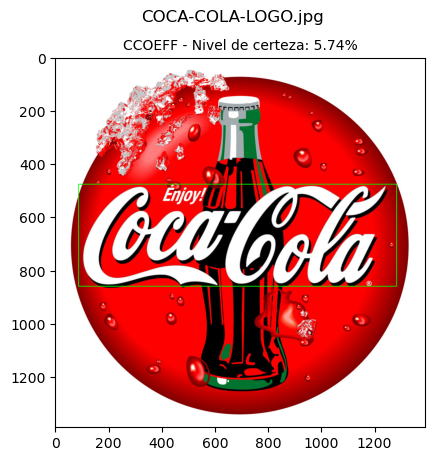

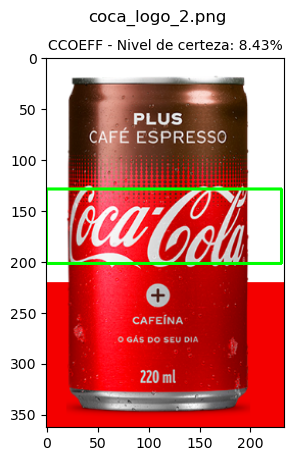

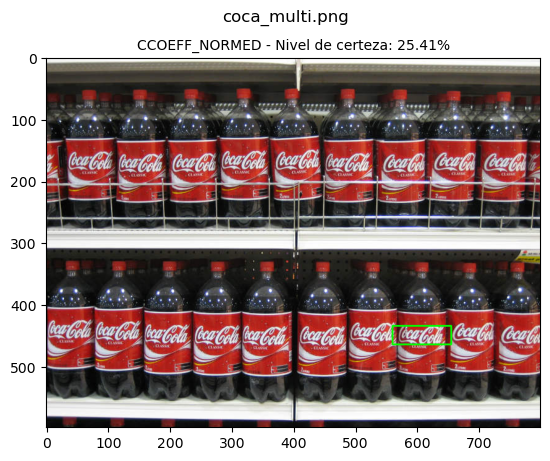

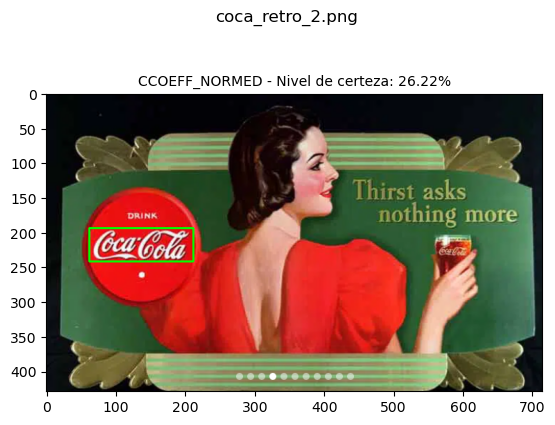

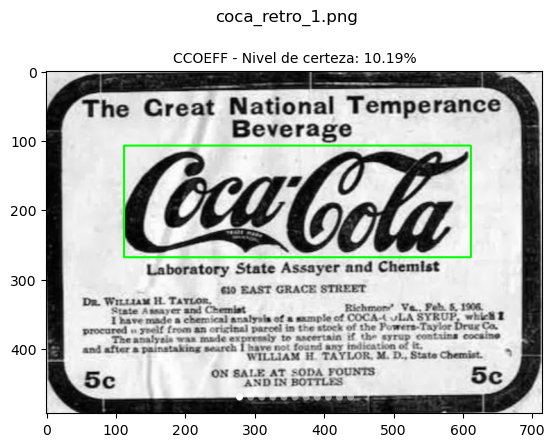

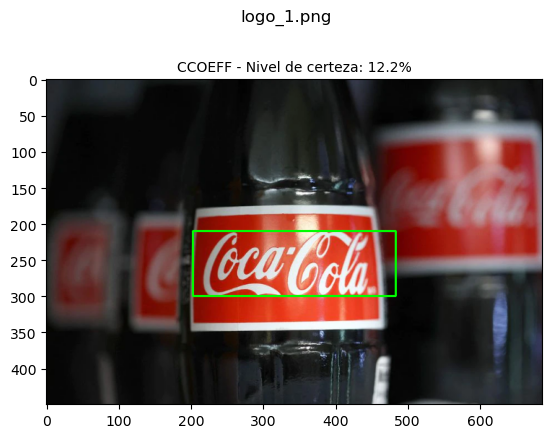

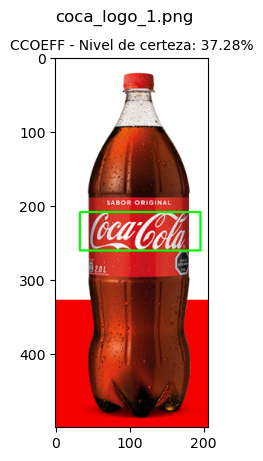

In [79]:
# Recorrer todas las imágenes y aplicar Template Matching para una única detección
for i in all_files: 

    image_bgr = cv.imread(i)
    image_output_rgb, metricVal, template_size, method, metric = templateMatch(image_bgr, template_bgr, 75)

    # Mostrar detección
    plt.figure()
    plt.imshow(image_output_rgb)
    plt.suptitle(str(i).split('/')[-1], fontsize=12)
    plt.title(f"{method} - Nivel de certeza: {round(metric, 2)}%", fontsize=10)
    plt.show()



## 2.

Plantear y validar un algoritmo para múltiples detecciones en la imagen ["coca_multi.png"](./images/coca_multi.png) con el mismo template.

In [83]:
image_multi = cv.imread('./images/coca_multi.png')

In [85]:
def templateMatchMulti(image, template, threshold):
    """
    Aplica template matching
    para múltiples detecciones
    Inputs:
    * image: imagen a procesar en formato BGR
    * template: imagen del patrón a buscar en formato BGR
    * threshold: umbral empleado para el match
    Outputs:
    * Array de detecciones con la métrica obtenida
    """

     # Imagen de salida RGB
    image_output_rgb = cv.cvtColor(image.copy(), cv.COLOR_BGR2RGB)
    boxes = []
    confidences = []
    
    # Convertir a escala de grises la imagen y el template
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    # Aplicar Canny para detectar bordes en la imagen y el template
    edges_image = cv.Canny(image_gray, 100, 200)
    edges_template = cv.Canny(template_gray, 100, 200)

    w, h = template_gray.shape[::-1]
    result = cv.matchTemplate(edges_image, edges_template, cv.TM_CCOEFF_NORMED)

    loc = np.where( result >= threshold)
    
    for pt in zip(*loc[::-1]):
        boxes.append([pt[0], pt[1], pt[0] + w, pt[1] + h])
        confidences.append(result[pt[::-1]])

    # Convertir el formato
    boxes = np.array(boxes, dtype=np.float32)
    confidences = np.array(confidences, dtype=np.float32)

    # Aplicar NMS para filtrar detecciones superpuestas
    nms_threshold = 0.6  
    score_threshold = threshold
    indexes = cv.dnn.NMSBoxes(boxes.tolist(), confidences.tolist(), score_threshold=score_threshold, nms_threshold=nms_threshold)
    
    # Filtrar las cajas utilizando los índices devueltos
    filtered_boxes = [boxes[i] for i in indexes]
    filtered_confidences = [confidences[i] for i in indexes]
    
    # Marcar sobre la imagen las cajas filtradas
    for box in filtered_boxes:
        x1, y1, x2, y2 = box
        cv.rectangle(image_output_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

    filtered_points = np.array([(int(box[0]), int(box[2])) for box in filtered_boxes])
    arr_results = np.array([[x, y] for x, y in zip(filtered_points, filtered_confidences)], dtype=object)
    
    return image_output_rgb, arr_results


In [87]:
def templateMatchMultiFull (image_multi, template_multi, threshold):
    """
    Aplica template matching 
    con los diferentes tamaños de template y devuelve
    el escenario que tenga mayores coincidencias
    """
    matches = 0
    image_multi_rgb_r = cv.cvtColor(image_multi, cv.COLOR_BGR2RGB)
    results_r = None

    template_sizes = templateSizes(image_multi.shape, template_multi.shape, 10, 20)

    for s in template_sizes:
        image_multi_rgb, results = templateMatchMulti(image_multi, scaleTemplate(template_multi, s), threshold)
        if (results.shape[0] > matches):
            image_multi_rgb_r, results_r = image_multi_rgb, results

    return image_multi_rgb_r, results_r

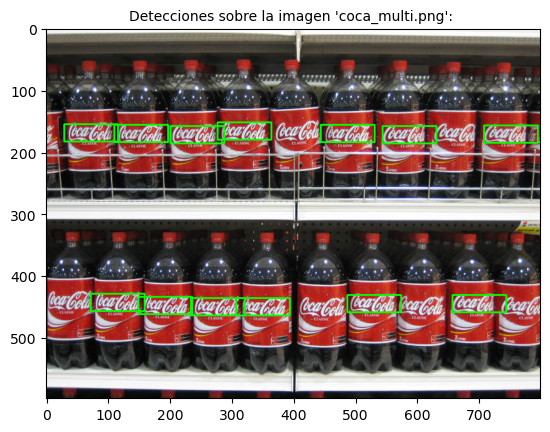

Esquina superior izquierda del bbox Nivel de confianza
1                           [444, 531]             21.94%
2                            [29, 116]             21.89%
3                           [277, 364]             21.61%
4                           [708, 795]             19.35%
5                           [149, 236]             19.27%
6                           [234, 321]             18.88%
7                            [72, 159]             18.35%
8                           [544, 631]             18.33%
9                           [657, 744]             18.11%
10                          [487, 574]             17.75%
11                          [201, 288]             16.77%
12                          [110, 197]             15.95%
13                          [307, 394]             15.17%

In [89]:
image_multi_rgb, results = templateMatchMultiFull(image_multi, cropTemplate(template_bgr), 0.15)

# Mostrar detecciones
plt.figure()
plt.imshow(image_multi_rgb)
plt.title(f"Detecciones sobre la imagen 'coca_multi.png': ", fontsize=10)
plt.show()

results_table = pd.DataFrame(results)
results_table[1] = results_table[1].apply(lambda x: f'{x*100:,.2f}%')

# Cambiar el índice para comenzar desde 1 y que represente la cantidad de matches
results_table.reset_index(drop=True, inplace=True) 
results_table.index += 1  

results_table.columns = ['Esquina superior izquierda del bbox', 'Nivel de confianza']
display(results_table)



## 3.

Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [94]:
def generalTemplateMatch(image, template, threshold_p):
    """
    Aplica template matching sobre la imagen dada 
    Inputs:
    * image: imagen a procesar en formato BGR
    * template: imagen del patrón a buscar en formato BGR
    * threshold_p: umbral empleado para tomar decisiones de pre-procesamiento
    Outputs:
    * Imagen RGB con bounding box/es indicando la/s detección/es
    * Array con los resultados obtenidos (bounding boxes y métrica de confianza
    * Método de evaluación
    """

    # Imagen de salida RGB
    image_output_rgb = cv.cvtColor(image.copy(), cv.COLOR_BGR2RGB)
    # Recortar los bordes del template
    cropped_template = cropTemplate(template)

    # Convertir a escala de grises la imagen 
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Pre-procesamiento de la imagen en caso de ser necesario
    image_gray, method = preProcessImg(image_gray, threshold_p)
    
    # Aplicar detección de bordes
    edges_image = cv.Canny(image_gray, 100, 200)

    # Obtener valores escalados para el template
    template_sizes = templateSizes(edges_image.shape, cropped_template.shape, 10, 100)
    
    # Template Matching
    boxes = [] # array de bounding boxes
    confidences = [] # array de niveles de confianza

    # Escalar el template para la búsqueda
    for t_shape in template_sizes:

        # Ajustar el tamaño del template
        resized_template = scaleTemplate(cropped_template, t_shape)
 
        # Pasar template a escala de grises y extraer bordes
        template_gray = cv.cvtColor(resized_template, cv.COLOR_BGR2GRAY)
        edges_template = cv.Canny(template_gray, 100, 200)
        w, h = edges_template.shape[::-1]
        
        # match entre el template escalado y la imagen de bordes
        # utilizando el método seleccionado en función de la imagen de entrada
        result = cv.matchTemplate(edges_image, edges_template, eval('cv.TM_'+ method))

        # Establecer los umbrales de detección según el método utilizado
        if method.endswith("NORMED"):
            # Umbral para detecciones entre 0 y 1
            threshold_n = 0.15
            nms_threshold = 0.6  
        else:
            # Umbral para métrica no normalizada
            threshold_n = 10*10**6
            nms_threshold = 0.1  

        # Detecciones sobre el umbral            
        loc = np.where( result >= threshold_n)
       
        for pt in zip(*loc[::-1]):
            boxes.append([pt[0], pt[1], pt[0] + w, pt[1] + h])
            confidences.append(result[pt[::-1]])

    # Convertir el formato para NMS
    np_boxes = np.array(boxes, dtype=np.float32)
    np_confidences = np.array(confidences, dtype=np.float32)

    # Aplicar NMS para filtrar detecciones superpuestas
    score_threshold = threshold_n
    
    indexes = cv.dnn.NMSBoxes(np_boxes.tolist(), np_confidences.tolist(), score_threshold=score_threshold, nms_threshold=nms_threshold)
   
    # Filtrar las cajas utilizando los índices devueltos
    filtered_boxes = [np_boxes[i] for i in indexes]
    confLevels = [np_confidences[i] for i in indexes]

    # Actualizar el % de confianza
    for j in range(0, len(confLevels)):
        b = filtered_boxes[j]
        fx1, fy1, fx2, fy2 = filtered_boxes[j]
        template_size = (int(fy2 - fy1), int(fx2 - fx1), 3)
        confLevels[j] = getMetric(edges_image, template_size, confLevels[j], (int(b[0]), int(b[1])), method)
    

    del_indexes = []
    # Marcar sobre la imagen las cajas filtradas
    for index, bbox in enumerate(filtered_boxes):
        x1, y1, x2, y2 = bbox
        if confLevels[index] > 5:
            cv.rectangle(image_output_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        else:
            # Descartar si el porcentaje de confianza no llega al 5%
            del_indexes.append(index)

    filtered_boxes = [item for i, item in enumerate(filtered_boxes) if i not in del_indexes]
    confLevels = [item for i, item in enumerate(confLevels) if i not in del_indexes]
    
    return image_output_rgb, [filtered_boxes, confLevels], method


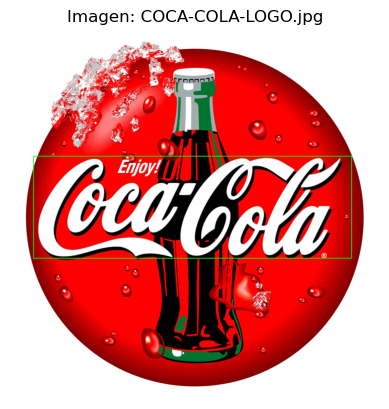

Cantidad de detecciones: 1.

Método de detección: CCOEFF.



Posición  % Confianza Tamaño template
1  [88, 477]         5.74     (383, 1194)

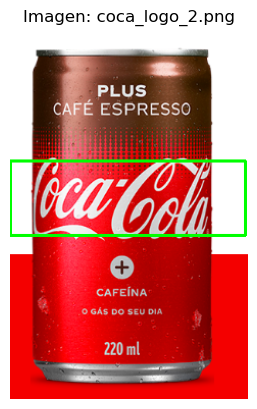

Cantidad de detecciones: 1.

Método de detección: CCOEFF.



Posición  % Confianza Tamaño template
1  [0, 129]         8.43       (73, 230)

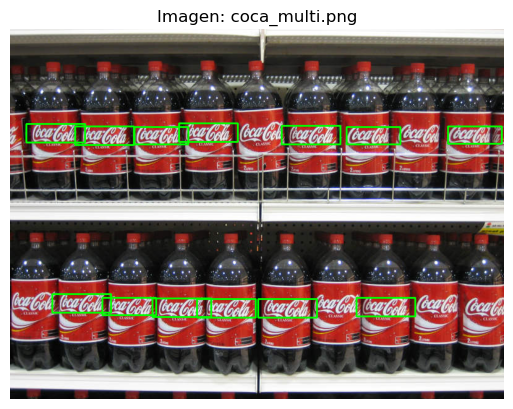

Cantidad de detecciones: 13.

Método de detección: CCOEFF_NORMED.



Posición  % Confianza Tamaño template
1   [560, 434]        25.41        (30, 95)
2    [26, 153]        25.38        (30, 95)
3    [68, 428]        24.32        (30, 95)
4   [273, 152]        23.24        (30, 95)
5   [230, 435]        22.57        (30, 95)
6   [439, 156]        22.45        (30, 95)
7   [105, 157]        20.52        (30, 95)
8   [708, 157]        19.35        (28, 87)
9   [149, 434]        19.27        (28, 87)
10  [401, 436]        18.97        (30, 95)
11  [544, 158]        18.33        (28, 87)
12  [201, 158]        16.77        (28, 87)
13  [302, 436]        15.48        (30, 95)

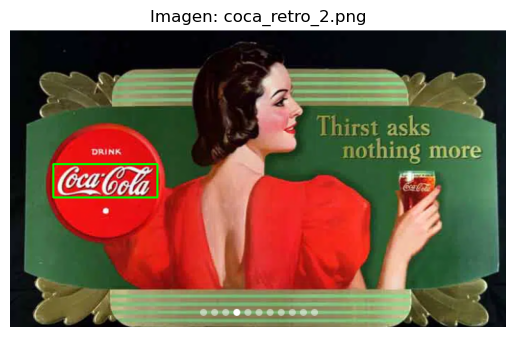

Cantidad de detecciones: 1.

Método de detección: CCOEFF_NORMED.



Posición  % Confianza Tamaño template
1  [62, 194]        26.22       (48, 150)

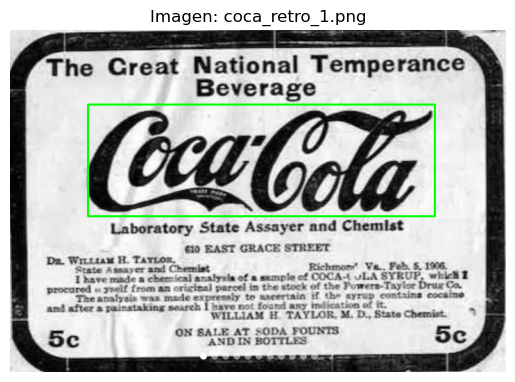

Cantidad de detecciones: 1.

Método de detección: CCOEFF.



Posición  % Confianza Tamaño template
1  [112, 107]        10.19      (161, 500)

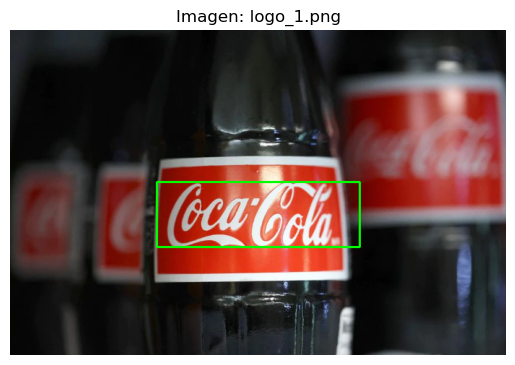

Cantidad de detecciones: 1.

Método de detección: CCOEFF.



Posición  % Confianza Tamaño template
1  [203, 210]         12.2       (90, 281)

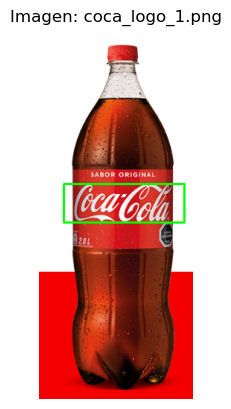

Cantidad de detecciones: 1.

Método de detección: CCOEFF.



Posición  % Confianza Tamaño template
1  [33, 209]        37.28       (52, 162)

In [96]:
# Recorrer todas las imágenes y aplicar Template Matching para una o múltiples detecciones
for i in all_files: 

    image_bgr = cv.imread(i)
    
    image_output_rgb, results, method = generalTemplateMatch(image_bgr, template_bgr, 75)
    
    # Mostrar las detecciones
    print("\n\n\n")
    plt.figure()
    plt.imshow(image_output_rgb)
    plt.axis('off')  
    plt.title(f"Imagen: {str(i).split('/')[-1]}", fontsize=12)
    plt.show()

    print (f"Cantidad de detecciones: {len(results[0]) }.\n")
   
    if (len(results) > 0):
        print(f"Método de detección: {method}.\n")

    sizes_arr = []
    for x1, y1, x2, y2 in results[0]:
        sizes_arr.append((int(y2-y1), int(x2-x1)))
    
    res_t = {
        'Posición': results[0],
        '% Confianza': results[1],
        'Tamaño template': sizes_arr
        }
    
    results_table = pd.DataFrame(res_t)

    results_table['Posición'] = results_table['Posición'].apply(lambda x: [int(elem) for elem in x[:2]])
    results_table['% Confianza'] = results_table['% Confianza'].apply(lambda x: round(x, 2))
    results_table.reset_index(drop=True, inplace=True) 
    results_table.index += 1  

    display(results_table)

    